In [117]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [118]:
# Set random seed for reproducibility
np.random.seed(42)

In [119]:
# Load the dataset
data = pd.read_csv("heart-attack-risk-prediction-dataset.csv")

In [120]:
data.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Heart Attack Risk (Text),Gender,Systolic blood pressure,Diastolic blood pressure
0,0.595506,0.314286,0.047663,0.0,0.0,1.0,0.0,0.0,0.208326,0,...,0.0,0.333333,0.0,0.227018,0.048229,0.036512,0,Male,0.600000,0.534884
1,0.595506,0.096429,0.047663,1.0,1.0,1.0,1.0,1.0,0.752420,1,...,2.0,0.666667,0.0,0.227018,0.048229,0.036512,0,Male,0.574194,0.569767
2,0.595506,0.189286,0.047663,0.0,0.0,1.0,0.0,1.0,0.200998,2,...,4.0,1.000000,0.0,0.227018,0.048229,0.036512,0,Male,0.187097,0.674419
3,0.078652,0.960714,0.071494,1.0,1.0,1.0,1.0,1.0,0.090557,2,...,1.0,0.500000,0.0,0.227018,0.048229,0.036512,0,Male,0.645161,0.593023
4,0.078652,0.792857,0.071494,1.0,0.0,1.0,1.0,0.0,0.601030,2,...,1.0,0.166667,0.0,0.227018,0.048229,0.036512,0,Male,0.251613,0.383721


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              9651 non-null   float64
 1   Cholesterol                      9651 non-null   float64
 2   Heart rate                       9651 non-null   float64
 3   Diabetes                         9377 non-null   float64
 4   Family History                   9377 non-null   float64
 5   Smoking                          9377 non-null   float64
 6   Obesity                          9377 non-null   float64
 7   Alcohol Consumption              9377 non-null   float64
 8   Exercise Hours Per Week          9651 non-null   float64
 9   Diet                             9651 non-null   int64  
 10  Previous Heart Problems          9377 non-null   float64
 11  Medication Use                   9377 non-null   float64
 12  Stress Level        

In [122]:
# Handle missing values (e.g., fill with median for numeric columns)
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

In [123]:
# Encode categorical variable 'Gender'
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])  # Male=1, Female=0

In [124]:
# Use 'Heart Attack Risk (Binary)' as target, drop redundant 'Heart Attack Risk (Text)'
X = data.drop(columns=['Heart Attack Risk (Binary)', 'Heart Attack Risk (Text)'])
y = data['Heart Attack Risk (Binary)']

In [125]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# Initialize and train the model with default parameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [127]:
# Predict and calculate accuracy
y_pred = xgb_model.predict(X_test)
basic_accuracy = accuracy_score(y_test, y_pred)
print(f"Basic XGBoost Accuracy: {basic_accuracy:.4f}")

Basic XGBoost Accuracy: 0.6442


<Figure size 1000x600 with 0 Axes>

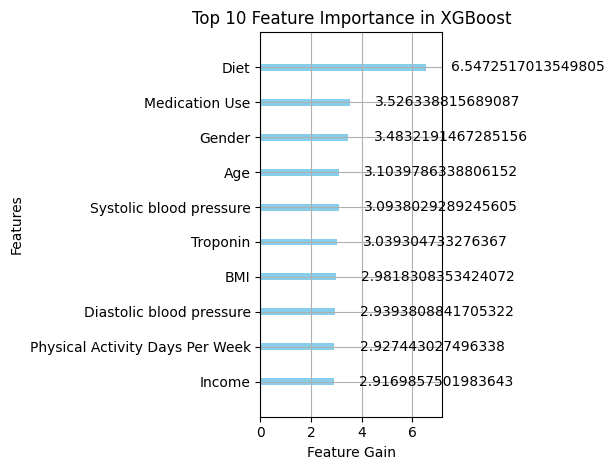

In [128]:
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain',
                    title="Top 10 Feature Importance in XGBoost",
                    xlabel="Feature Gain", color='skyblue')
plt.tight_layout()
plt.show()

In [129]:
# Extract and display top features
importances = xgb_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Top 5 Features by Importance:")
print(feature_importance_df.head())

Top 5 Features by Importance:
                    Feature  Importance
9                      Diet    0.088287
11           Medication Use    0.047551
22                   Gender    0.046970
0                       Age    0.041856
23  Systolic blood pressure    0.041719


In [130]:
# Hyperparameter Tuning
# Define parameter grid for tuning
param_grid = {
        'max_depth': [3, 5, 7, 8, 10, 15, 20],
        'learning_rate': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2]
        }

# Perform grid search
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                         'max_depth': [3, 5, 7, 8, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [131]:
# Best parameters and accuracy
best_params = grid_search.best_params_
tuned_accuracy = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Tuned Model CV Accuracy: {tuned_accuracy:.4f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 20}
Tuned Model CV Accuracy: 0.6579


In [132]:
# Train tuned model on full training set
tuned_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
tuned_model.fit(X_train, y_train)
tuned_pred = tuned_model.predict(X_test)
tuned_test_accuracy = accuracy_score(y_test, tuned_pred)
print(f"Tuned Model Test Accuracy: {tuned_test_accuracy:.4f}")

Tuned Model Test Accuracy: 0.6758


In [133]:
# Visualization: Tuning Results
# Extract results for plotting
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot(index='param_max_depth', columns='param_learning_rate',
                            values='mean_test_score')

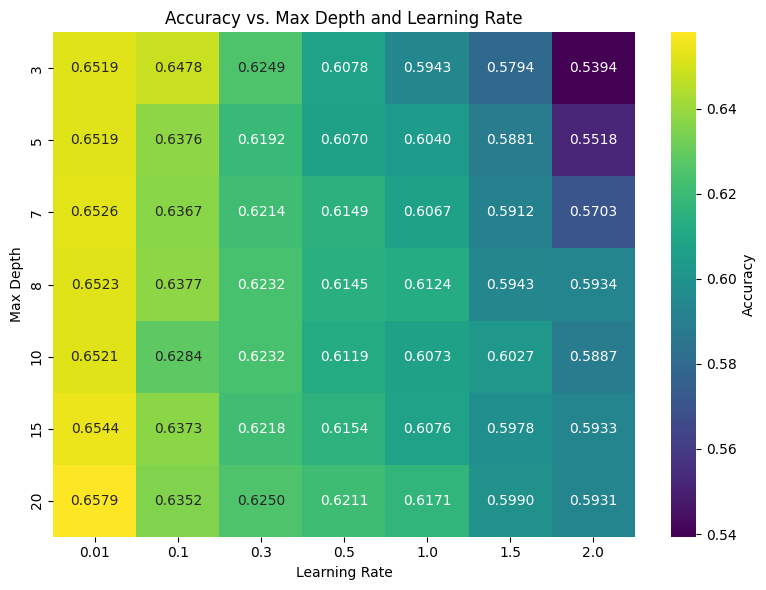

In [134]:
# Heatmap of accuracy vs. hyperparameters
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'Accuracy'})
plt.title("Accuracy vs. Max Depth and Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

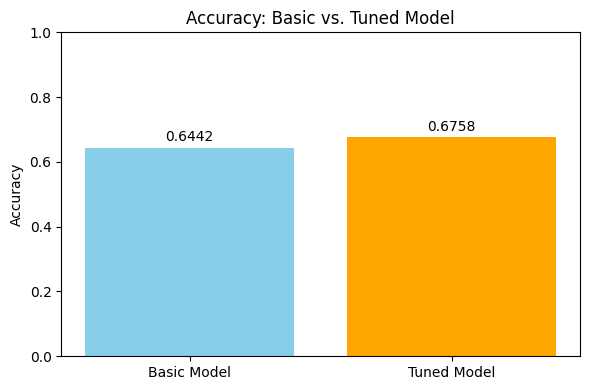

In [135]:
# Before vs. After Tuning Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(['Basic Model', 'Tuned Model'], [basic_accuracy, tuned_test_accuracy],
        color=['skyblue', 'orange'])
plt.title("Accuracy: Basic vs. Tuned Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.text(0, basic_accuracy + 0.02, f'{basic_accuracy:.4f}', ha='center')
plt.text(1, tuned_test_accuracy + 0.02, f'{tuned_test_accuracy:.4f}', ha='center')
plt.tight_layout()
plt.show()

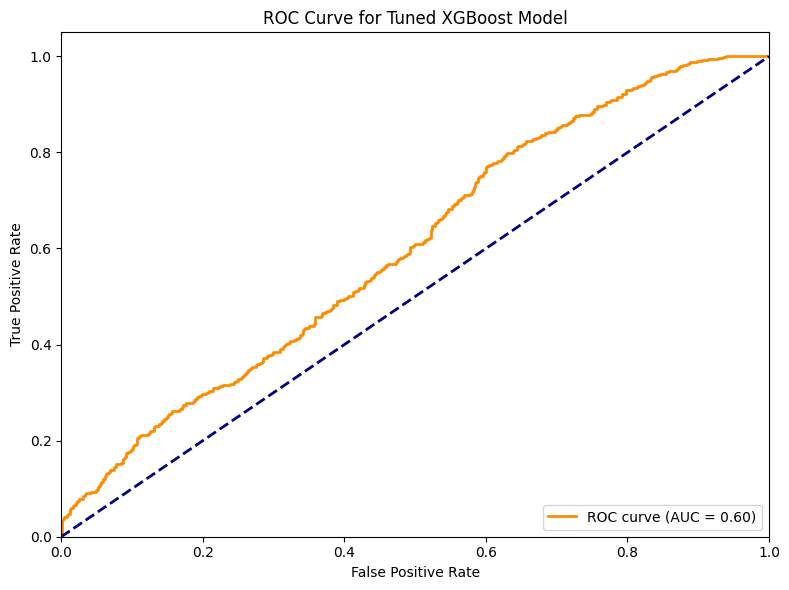

In [136]:
# ROC Curve for Tuned Model
# Compute ROC curve and AUC
y_prob = tuned_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost Model')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()